In [1]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics 
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.matrix as smatrix
import random
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, KFold
%pylab inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [134]:
X_train = pd.read_csv('x_train.csv', header = 0, sep = ';')
X_test = pd.read_csv('x_test.csv', header = 0, sep = ';')

y_train = pd.read_csv('y_train.csv', header = None)
y_train.columns = ['y']

In [27]:
X_train = pd.concat([X_train, y_train], axis = 1)

## фичинженеринг

In [97]:
X_train['f1'] = X_train.totalNumOfAttempts - X_train.attemptsOnTheHighestLevel
X_train['f2'] = X_train.numberOfBoostersUsed - X_train.fractionOfUsefullBoosters
#X_train['f3'] = X_train.numberOfAttemptedLevels - X_train.maxPlayerLevel 
X_train['f4'] = X_train.averageNumOfTurnsPerCompletedLevel * X_train.maxPlayerLevel
#X_train['f5'] = X_train.totalBonusScore / X_train.totalScore
#X_train['f6'] = X_train.attemptsOnTheHighestLevel / X_train.totalNumOfAttempts
#X_train['f7'] = X_train.fractionOfUsefullBoosters / X_train.numberOfBoostersUsed
#X_train['f8'] = X_train.maxPlayerLevel / X_train.numberOfDaysActuallyPlayed
#X_train['f9'] = X_train.numberOfAttemptedLevels / X_train.maxPlayerLevel
X_train['totalScore'] = np.log(X_train['totalScore'] + 0.000001)
X_train['attemptsOnTheHighestLevel'] = np.log(X_train['attemptsOnTheHighestLevel'] + 0.000001)
X_train['totalNumOfAttempts'] = np.log(X_train['totalNumOfAttempts'] + 0.000001)
X_train['kvant'] = X_train['totalBonusScore'] > 2300
X_train['kv_1'] = X_train['totalScore'] > 550000


X_test['f1'] = X_test.totalNumOfAttempts - X_test.attemptsOnTheHighestLevel
X_test['f2'] = X_test.numberOfBoostersUsed - X_test.fractionOfUsefullBoosters
#X_test['f3'] = X_test.numberOfAttemptedLevels - X_test.maxPlayerLevel 
X_test['f4'] = X_test.averageNumOfTurnsPerCompletedLevel * X_test.maxPlayerLevel
#X_test['f5'] = X_test.totalBonusScore / X_test.totalScore 
#X_test['f6'] = X_test.attemptsOnTheHighestLevel / X_test.totalNumOfAttempts
#X_test['f7'] = X_test.fractionOfUsefullBoosters / X_test.numberOfBoostersUsed
#X_test['f8'] = X_test.maxPlayerLevel / X_test.numberOfDaysActuallyPlayed
#X_test['f9'] = X_test.numberOfAttemptedLevels / X_test.maxPlayerLevel
X_test['totalScore'] = np.log(X_test['totalScore'] + 0.000001)
X_test['attemptsOnTheHighestLevel'] = np.log(X_test['attemptsOnTheHighestLevel'] + 0.000001)
X_test['totalNumOfAttempts'] = np.log(X_test['totalNumOfAttempts'] + 0.000001)
X_test['kvant'] = X_test['totalBonusScore'] > 2300
X_test['kv_1'] = X_test['totalScore'] > 550000

In [32]:
X_train.isnull().sum()

maxPlayerLevel                        0
numberOfAttemptedLevels               0
attemptsOnTheHighestLevel             0
totalNumOfAttempts                    0
averageNumOfTurnsPerCompletedLevel    0
doReturnOnLowerLevels                 0
numberOfBoostersUsed                  0
fractionOfUsefullBoosters             0
totalScore                            0
totalBonusScore                       0
totalStarsCount                       0
numberOfDaysActuallyPlayed            0
f1                                    0
f2                                    0
f4                                    0
dtype: int64

In [38]:
X_train['averageNumOfTurnsPerCompletedLevel'].min()

-13.815510557964274

In [3]:
from sklearn import cross_validation
XX_train, H_data, yy_train, h_test = cross_validation.train_test_split(X_train, y_train, 
                                                                                     test_size = 0.2)

In [19]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

d_mean= X_train.median(axis=0)
col = ['f5', 'f7']
for c in col:
    X_train[c + '_nan_'] = pd.isnull(X_train[c])
    d_mean[c + '_nan_'] = 0
X_train = X_train.fillna(d_mean)


col = ['f5', 'f7']
for c in col:
    X_test[c + '_nan_'] = pd.isnull(X_test[c])
    d_mean[c + '_nan_'] = 0
X_test = X_test.fillna(d_mean)

In [30]:
X_train[:10]

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,f1,f2,f4
0,39,10,3,17,3.196403,1,5,0.400000,2650000,1375,21,2,14,4.600000,953.333333
1,21,22,19,55,2.835884,1,6,0.333333,5614000,3825,51,4,36,5.666667,357.954545
2,5,6,1,6,2.128232,0,1,1.000000,857000,1150,14,1,5,0.000000,42.000000
3,21,2,5,6,2.944439,0,1,0.000000,120000,0,1,1,1,1.000000,399.000000
4,4,5,1,5,2.261763,0,1,1.000000,857000,1075,12,1,4,0.000000,38.400000
5,0,1,1,1,1.098612,0,0,0.000000,113000,250,0,1,0,0.000000,0.000000
6,13,14,2,19,2.740840,0,5,0.800000,3831000,2875,34,2,17,4.200000,201.500000
7,13,14,5,26,2.692546,0,4,0.500000,3458000,2375,31,2,21,3.500000,192.000000
8,2,3,1,3,2.036882,0,0,0.000000,420000,750,6,1,2,0.000000,15.333333
9,1,2,3,5,1.098612,1,0,0.000000,113000,250,3,1,2,0.000000,3.000000


In [92]:
from sklearn.datasets import load_iris, load_boston
import xgboost as xgb
import xgbfir


# doing all the XGBoost magic
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
param = {'min_child_weight': 90,
        'eta': 0.03,
        #'colsample_bytree': 1.0,
        'max_depth': 5,
        #'subsample': 1.0,
        #'alpha': 1,
        #'gamma': 1,
        #'silent': 1,
        'eval_metric' : 'logloss',
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 195

xgtrain = xgb.DMatrix(X_train, y_train)
bst = xgb.train(param, xgtrain, num_round)

# saving to file with proper feature names
xgbfir.saveXgbFI(bst, feature_names=X_train.columns, MaxInteractionDepth= 10, OutputXlsxFile = 'irisFI.xlsx')

In [53]:
print y_train[y_train.y == 0].shape
print y_train[y_train.y == 1].shape

(18001, 1)
(7288, 1)


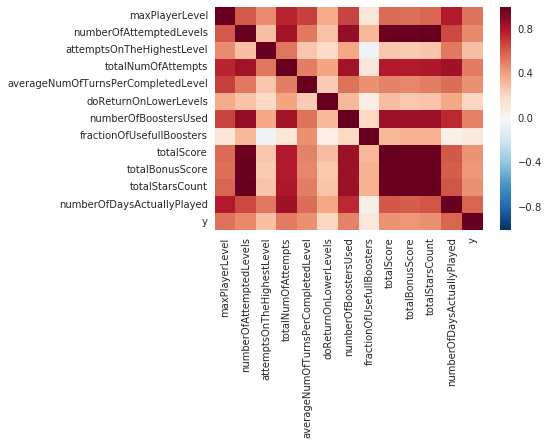

In [37]:
import seaborn as sns
CorrKoef = X_train.corr()
#pylab.figure(figsize=(50, 25))
sns.heatmap(CorrKoef, annot=False)

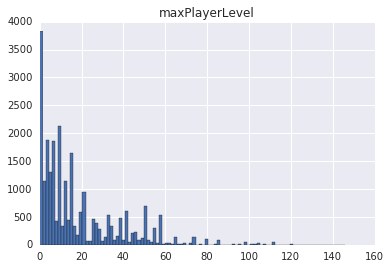

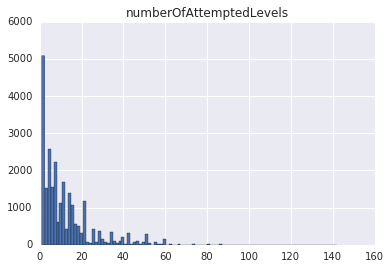

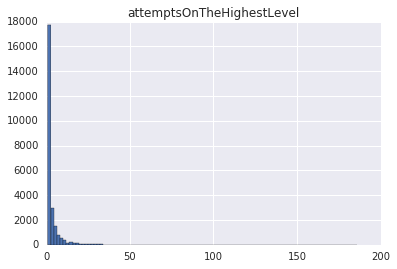

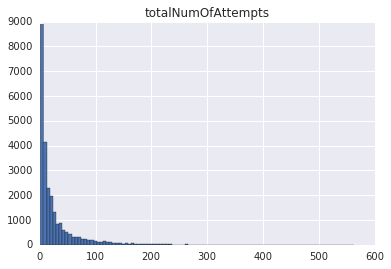

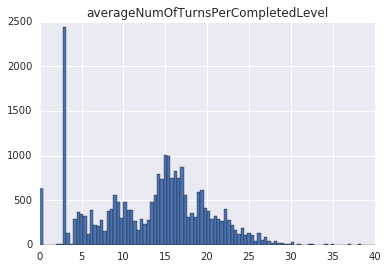

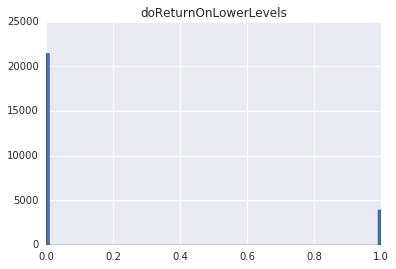

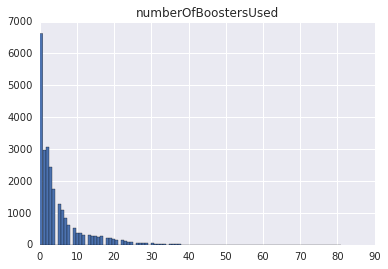

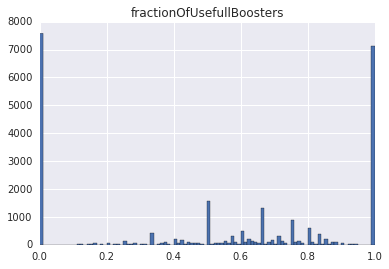

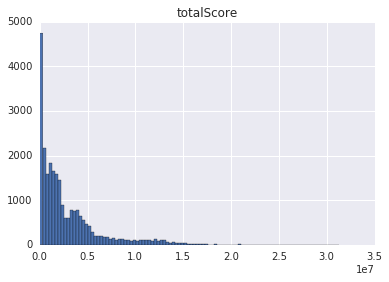

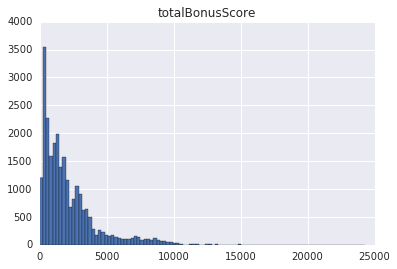

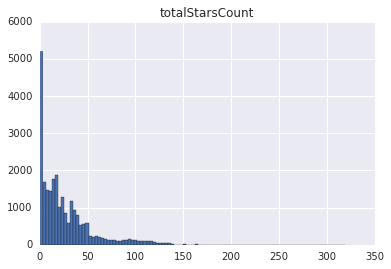

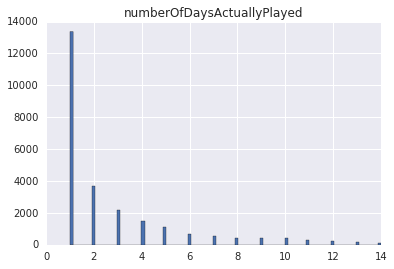

In [56]:
for i in X_train.columns:
    plt.title(i)
    #pylab.figure(figsize=(8, 6))
    plt.hist(X_train[i], bins=100)
    plt.show()

# Модели первого уровня

## Тюнинг

In [137]:
%%time
param = {'min_child_weight': 10,
        'eta': 0.02,
        #'colsample_bytree': 0.9,
        'max_depth': 7,
        #'subsample': 0.3,
        #'alpha': 1,
        #'gamma': 1,
        #'silent': 1,
        'eval_metric' : 'logloss',
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 300

xgtrain = xgb.DMatrix(XX_train, yy_train)

t = xgb.cv(param, xgtrain, num_boost_round=num_round, nfold=5, show_stdv=0, seed=0, verbose_eval=50)
print t['test-logloss-mean'].min()
print t['test-logloss-mean'].argmin() + 1

[0]	train-logloss:0.682436	test-logloss:0.682905
[50]	train-logloss:0.426582	test-logloss:0.447454
[100]	train-logloss:0.357438	test-logloss:0.39867
[150]	train-logloss:0.332969	test-logloss:0.389081
[200]	train-logloss:0.32224	test-logloss:0.387538
[250]	train-logloss:0.315005	test-logloss:0.388208
0.3875052
196
CPU times: user 45.2 s, sys: 352 ms, total: 45.6 s
Wall time: 14.5 s


In [ ]:
0.381135

In [133]:
clf = xgb.XGBClassifier(max_depth=8,
                        learning_rate=0.02,
                        n_estimators=245,
                        silent=True,
                        objective='binary:logistic',
                        nthread=-1,
                        #gamma=0,
                        min_child_weight=100,
                        #max_delta_step=0,
                        subsample=0.83,
                        #colsample_bytree=1,
                        #colsample_bylevel=1,
                        #reg_alpha=0,
                        #reg_lambda=1,
                        #scale_pos_weight=1,
                        #base_score=0.5,
                        seed=10,
                        missing=None)

print cross_val_score(clf, X_train, y_train.y, scoring='neg_log_loss', cv=5, verbose=1).mean()

-0.381382837481


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s finished


In [ ]:
-0.381692472011


In [19]:
clf.fit(XX_train, yy_train)
log_loss(h_test, clf.predict_proba(H_data))

0.37954981211232613

In [69]:
0.3811612
0.381396

0.382925

In [126]:
import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
forest_regressor = sklearn.ensemble.RandomForestClassifier(n_estimators=295,
                                       #criterion='mlog_loss',
                                       max_depth=8,
                                       min_samples_split=10,
                                       min_samples_leaf=7,
                                       #min_weight_fraction_leaf=0.0,
                                       max_features='auto',
                                       max_leaf_nodes=None,
                                       bootstrap=True,
                                       #oob_score=False,
                                       n_jobs=-1,
                                       random_state=13)

et = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, bootstrap=True,
                          #max_features=0.3, 
                          max_depth=7, 
                          criterion='gini',
                         )
print cross_val_score(forest_regressor, X_train, y_train.y, scoring='neg_log_loss', cv=5, verbose=1).mean()

-0.383386457496


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.1s finished


In [ ]:
0.382641140519
0.382643069297
0.383204495745
0.383206985197
0.383211369176
0.383370806269
0.383386457496

# Предсказания 

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)


In [81]:
from sklearn.cross_validation import KFold
cv = KFold(X_train.shape[0], n_folds=5, random_state=42)

In [69]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1e-2, penalty='l1')

preds_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')
preds_test = clf.fit(X_train, y_train).predict_proba(X_test)
                     
                     
preds_train = pd.DataFrame(preds_train)
preds_train.to_csv('stacking1/lin_train.csv', index=False, header = 0)
preds_test = pd.DataFrame(preds_test)
preds_test.to_csv('stacking1/lin_test.csv', index=False, header = 0)


In [70]:
tr = pd.read_csv('stacking1/lin_train.csv', header = None)
log_loss(y_train, tr)

0.39817144319022629

In [107]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=295,
                                       #criterion='mlog_loss',
                                       max_depth=8,
                                       min_samples_split=10,
                                       min_samples_leaf=7,
                                       #min_weight_fraction_leaf=0.0,
                                       max_features='auto',
                                       max_leaf_nodes=None,
                                       bootstrap=True,
                                       #oob_score=False,
                                       n_jobs=-1,
                                       random_state=13)

preds_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')
preds_test = clf.fit(X_train, y_train).predict_proba(X_test)
preds_train = pd.DataFrame(preds_train)
preds_train = preds_train.ix[:, 1]
preds_train.to_csv('stacking1/f1_sc_train.csv', index=False, header = 0)
preds_test = pd.DataFrame(preds_test)
preds_test = preds_test.ix[:, 1]
preds_test.to_csv('stacking1/f1_sc_test.csv', index=False, header = 0)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [116]:
tr = pd.read_csv('stacking1/f1_sc_train.csv', header = None)
log_loss(y_train, tr)

0.38258262575798035

In [120]:
clf = xgb.XGBClassifier(max_depth=5,
                        learning_rate=0.02,
                        n_estimators=245,
                        silent=True,
                        objective='binary:logistic',
                        nthread=-1,
                        gamma=0,
                        min_child_weight=100,
                        #max_delta_step=0,
                        #subsample=0.3,
                        #colsample_bytree=1,
                        #colsample_bylevel=1,
                        #reg_alpha=0,
                        #reg_lambda=1,
                        #scale_pos_weight=1,
                        #base_score=0.5,
                        seed=10,
                        missing=None)

preds_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')
preds_test = clf.fit(X_train, y_train).predict_proba(X_test)
preds_train = pd.DataFrame(preds_train)
preds_train = preds_train.ix[:, 1]
preds_train.to_csv('stacking1/b_1_sc_train.csv', index=False, header = 0)
preds_test = pd.DataFrame(preds_test)
preds_test = preds_test.ix[:, 1]
preds_test.to_csv('stacking1/b_1_sc_test.csv', index=False, header = 0)

In [122]:
tr = pd.read_csv('stacking1/b_1_sc_train.csv', header = None)
log_loss(y_train, tr)

0.38175116480266502

In [96]:
%%time
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=200)
neigh.fit(X_train, y_train) 
preds_train = neigh.predict_proba(X_train)
knn_pred = neigh.predict_proba(X_train)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


CPU times: user 2.83 s, sys: 188 ms, total: 3.02 s
Wall time: 3.02 s


In [97]:
log_loss(y_train, knn_pred)

0.47775367180359751

# Корелляция моделей

In [103]:
b_1 = pd.read_csv('stacking/boost_test.csv', header = None)
b_1.columns = ['boost_test']

b_2 = pd.read_csv('stacking/boost_test_1_2_3_4.csv', header = None)
b_2.columns = ['boost_test_1_2_3_4']

b_3 = pd.read_csv('stacking/boost_test_1_2_3_4_5_6_7_8_9.csv', header = None)
b_3.columns = ['boost_test_1_2_3_4_5_6_7_8_9']



f_1 = pd.read_csv('stacking/for_test.csv', header = None)
f_1.columns = ['for_test']

f_2 = pd.read_csv('stacking/for_test_1_2_3_4.csv', header = None)
f_2.columns = ['for_test_1_2_3_4']

f_3 = pd.read_csv('stacking/for_test_1_2_3_4_5_6_7_8_9.csv', header = None)
f_3.columns = ['for_test_1_2_3_4_5_6_7_8_9']

X_b = pd.concat([b_1, b_2, b_3], axis = 1)
X_f = pd.concat([f_1, f_2, f_3], axis = 1)





b_1_ = pd.read_csv('stacking/boost_train.csv', header = None)
b_1_.columns = ['boost_train']

b_2_ = pd.read_csv('stacking/boost_train_1_2_3_4.csv', header = None)
b_2_.columns = ['boost_train_1_2_3_4']

b_3_ = pd.read_csv('stacking/boost_test_1_2_3_4_5_6_7_8_9.csv', header = None)
b_3_.columns = ['boost_train_1_2_3_4_5_6_7_8_9']



f_1_ = pd.read_csv('stacking/for_train.csv', header = None)
f_1_.columns = ['for_train']

f_2_ = pd.read_csv('stacking/for_train_1_2_3_4.csv', header = None)
f_2_.columns = ['for_train_1_2_3_4']

f_3_ = pd.read_csv('stacking/for_train_1_2_3_4_5_6_7_8_9.csv', header = None)
f_3_.columns = ['for_train_1_2_3_4_5_6_7_8_9']

X_b_ = pd.concat([b_1_, b_2_, b_3_], axis = 1)
X_f_ = pd.concat([f_1_, f_2_, f_3_], axis = 1)


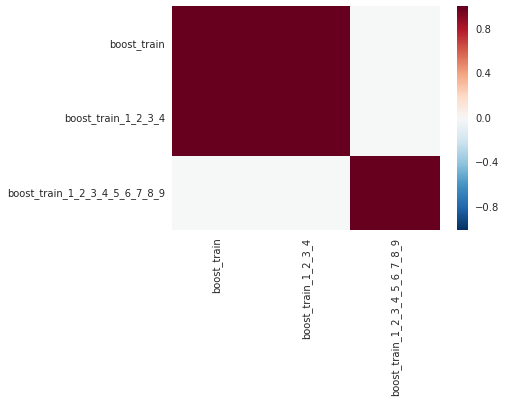

In [104]:
import seaborn as sns
CorrKoef = X_b_.corr()
#pylab.figure(figsize=(50, 25))
sns.heatmap(CorrKoef, annot=False)


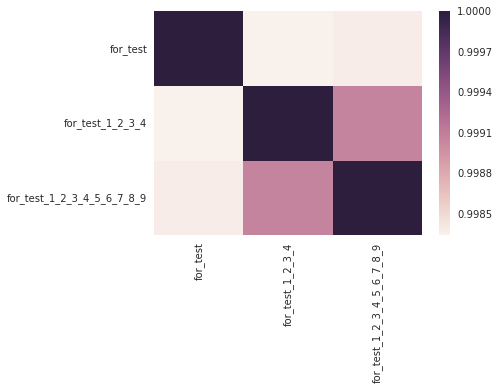

In [107]:

import seaborn as sns
CorrKoef = X_f.corr()
#pylab.figure(figsize=(50, 25))
sns.heatmap(CorrKoef, annot=False)

In [109]:
X_meta_train = pd.concat([X_b_, X_f_], axis = 1)
X_meta_test = pd.concat([X_b, X_f], axis = 1)

In [122]:
%%time
param = {'min_child_weight': 80,
        'eta': 0.03,
        #'colsample_bytree': 0.9,
        'max_depth': 3,
        'subsample': 0.3,
        #'alpha': 1,
        #'gamma': 1,
        #'silent': 1,
        'eval_metric' : 'logloss',
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 195

xgtrain = xgb.DMatrix(X_meta_train, y_train)

t = xgb.cv(param, xgtrain, num_boost_round=num_round, nfold=5, show_stdv=0, seed=0, verbose_eval=50)
print t['test-logloss-mean'].min()
print t['test-logloss-mean'].argmin() + 1

[0]	train-logloss:0.677801	test-logloss:0.67787
[50]	train-logloss:0.408535	test-logloss:0.411056
[100]	train-logloss:0.379914	test-logloss:0.384658
[150]	train-logloss:0.375556	test-logloss:0.382153
0.3818678
182
CPU times: user 23.3 s, sys: 428 ms, total: 23.7 s
Wall time: 3.94 s


In [125]:
X_meta_test.columns = X_meta_train.columns

In [123]:
num_round = 190

bst = xgb.train(param, xgtrain, num_round)

In [126]:
bst_pred = bst.predict(xgb.DMatrix(data = X_meta_test))

In [127]:
bst_pred = pd.DataFrame(bst_pred)
bst_pred.to_csv('first_stack.csv', index=False, header = 0)

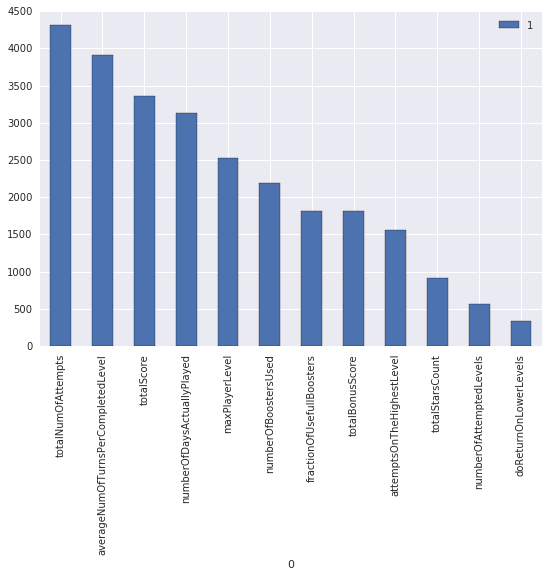

In [22]:
imp = pd.DataFrame(bst.get_fscore().items()).sort_values(1, ascending=False)
imp.index = imp[0]
imp[:80].plot(kind = "bar", figsize=(9, 6))
plt.show()
best = imp[:80].index

In [29]:
bst_pred = bst.predict(xgb.DMatrix(data = X_test))

In [24]:
print X_train.shape
print y_train.shape

(25289, 12)
(25289, 1)


In [30]:
bst_pred = pd.DataFrame(bst_pred)
bst_pred.to_csv('models/bst_pred.csv', index=False, header = 0)

In [86]:
forest_regressor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=495, n_jobs=-1, oob_score=False, random_state=13,
            verbose=0, warm_start=False)

In [87]:
pre = pd.DataFrame(pd.DataFrame(forest_regressor.predict_proba(X_test)).ix[:,1])

In [88]:
pre.to_csv('models/forest_pred.csv', index=False, header = 0)

In [89]:
bst_pred.shape

(25289, 1)

0.8737
1.0000


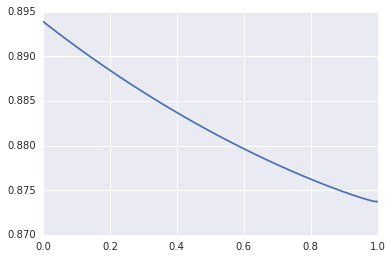

In [90]:
bst_pred = pd.read_csv('models/bst_pred.csv', header = None)
forest_pred = pd.read_csv('models/forest_pred.csv', header = None)

from sklearn.metrics import log_loss

weights = np.linspace(0, 1, 100)
scores = np.zeros_like(weights)
for index, alpha in enumerate(weights):
    preds = alpha * bst_pred.values + (1-alpha) * forest_pred.values
    scores[index] = log_loss(y_train, preds)
plt.plot(weights, scores)
print "{0:.4f}".format(np.min(scores))
print "{0:.4f}".format(weights[np.argmin(scores)])

In [91]:
print log_loss(y_train, bst_pred)
print log_loss(y_train, forest_pred)


0.873714399855
0.893898730995


In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

In [103]:
%%time
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X_train, y_train) 
knn_pred = neigh.predict_proba(X_test)
knn_pred = neigh.predict_proba(X_train)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


CPU times: user 1.61 s, sys: 20 ms, total: 1.63 s
Wall time: 1.63 s


In [104]:
print log_loss(y_train, knn_pred)

0.404997759471


In [13]:
knn_pred = pd.DataFrame(pd.DataFrame(knn_pred).ix[:, 1])

In [14]:
knn_pred.to_csv('models/knn_5.csv', index=False, header = 0)